# Permutation Feature Importance - Bias in Correlated Features

This notebook is based on my Master's Thesis with the title "Permutation Feature Importance for Correlated Variables: A
simulation study", in which I analysed the behavior of the Permutation Feature Importance technique for assessing variable importance in black box machine learning models. In my thesis, I simulated data with varying underlying datastructures and trained Random Forests and Ridge Regressors on the data and checked the behavior of the Permutation Feature Importance score, when predictor variables were correlated. <br>
In this notebook, I will show some of the main findings, while also expending the work by using a different method, namely XGBoost.
<br> <br> 
A special thanks at this point to my Supervisor Univ.-Prof. Dr. Frank Scharnowski and my Co-Supervisor Dipl.-Ing. Dr.techn. David Steyrl for helping me through my thesis. 

In [1]:
# loading necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
#!pip install lightgbm
import lightgbm as lgb
import scipy.stats

We start by generating a variance-covariance(VC)-matrix, specifying our desired correlations between the variables, and generating random data based on that VC-matrix. Then we tune a model, in this case LightGBM to our data. In the next step we create further datapoints and train a new model on this data point. We create even further datapoints on which we test the model and which we use to assess feature importance. These last two points are repeated a 100 times and the results for our prediction metric (R2) and our importance metric are averaged. <br>
We can tune the following parameters:
- the depth of each tree: max_depth
- the learning rate: learning_rate
- the regularization parameters L1 und L2: reg_alpha and reg_lambda
- the minimum number of data points required in a leaf: min_child_samples
- the number of boosting iterations: num_iterations
- The fraction of features used for each iteration: feature_fraction
- The fraction of samples used for each iteration: bagging_fraction

In this project, the datasets are kept simple, using only two predictor variables. For the first example, we set only one variable to be connected to the outcome variable.

In [2]:
mean = [0,0,0]
matrix = [[1, 0.5, 0], [0.5, 1, 0],[0, 0, 1]]
datamat = np.random.multivariate_normal(mean, matrix, 5000)
data = pd.DataFrame(datamat)

r2_list = []
imp1_list = []
imp2_list = []

y = datamat[:,0]
X = pd.DataFrame(datamat[:,(1,2)])
parameters = {
        'max_depth': [-1,3,5,7,10,13,16],
        'learning_rate': np.logspace(np.log10(0.01),np.log10(0.5), num = 20),
        'reg_alpha': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'reg_lambda': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'min_child_samples': [np.int64(x) for x in np.logspace(np.log10(1), np.log10(256), num = 20)],
        'n_estimators': [np.int64(x) for x in np.logspace(np.log10(50), np.log10(1000), num = 20)],
        'feature_fraction': [0.5,1],
        'bagging_fraction': np.logspace(np.log10(0.5),np.log10(1), num = 20),
    }
        
lgb_regr = lgb.LGBMRegressor(random_state = 13, verbose = -1)
CV = RandomizedSearchCV(estimator = lgb_regr, param_distributions = parameters, n_iter = 100, cv = 5)
CV.fit(X, y)
print(CV.best_estimator_)

for i in range(100) :
    datamat = np.random.multivariate_normal(mean, matrix, 5000)
    y = pd.DataFrame(datamat[:,0])
    X = pd.DataFrame(datamat[:,(1,2)])
    datamat_test = np.random.multivariate_normal(mean, matrix, 5000)
    y_test = pd.DataFrame(datamat_test[:,0])
    X_test = pd.DataFrame(datamat_test[:,(1,2)])

    lgb_regr_fin = CV.best_estimator_
    lgb_regr_fin.fit(X, y)
    result = permutation_importance(lgb_regr_fin, X_test, y_test, n_repeats=50)
    predictions = lgb_regr_fin.predict(X_test)
    r2 = round(r2_score(y_test, predictions), 2)
    r2_list.append(r2)
    imp1_list.append(result.importances_mean[0])
    imp2_list.append(result.importances_mean[1])

LGBMRegressor(bagging_fraction=0.9296353550084062, feature_fraction=1,
              learning_rate=0.01, max_depth=3, min_child_samples=2,
              n_estimators=331, random_state=13, reg_alpha=2.3357214690901213,
              reg_lambda=1.1288378916846888, verbose=-1)


mean_r2: 0.24, standard deviation: 0.01
feature1 importances: 0.47, standard deviation: 0.02
feature2 importances: 0.0, standard deviation: 0.0


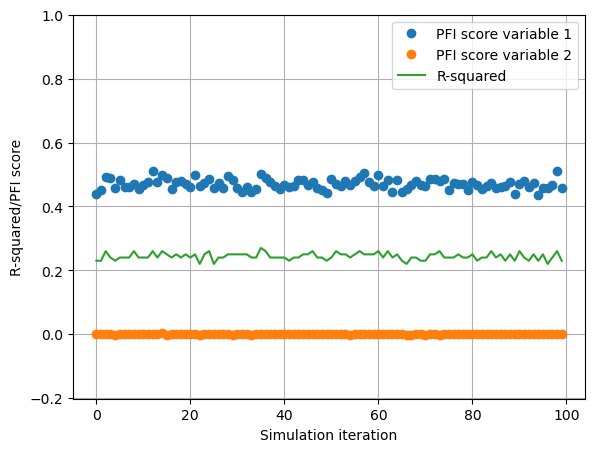

In [3]:
mean_imp1 = round(np.mean(imp1_list),2)
std_imp1 = round(np.std(imp1_list),2)
mean_imp2 = round(np.mean(imp2_list),2)
std_imp2 = round(np.std(imp2_list),2)
mean_r2 = round(np.mean(r2_list),2)
std_r2 = round(np.std(r2_list),2)
print('mean_r2: {}, standard deviation: {}' .format(mean_r2, std_r2))
print('feature1 importances: {}, standard deviation: {}' .format(mean_imp1, std_imp1))
print('feature2 importances: {}, standard deviation: {}' .format(mean_imp2, std_imp2))

a= plt.figure()
axes= a.add_axes([0.1,0.1,0.8,0.8])
maxylim = max(1, max(max(imp1_list), max(imp2_list))+ 0.2)
minylim = min(1, min(min(imp1_list), min(imp2_list)) - 0.2)
axes.set_ylim([minylim,maxylim])
plt.plot(imp1_list, marker='o', linestyle='None')
plt.plot(imp2_list, marker='o', linestyle='None')
plt.plot(r2_list, linestyle = '-')
plt.xlabel("Simulation iteration")
plt.ylabel("R-squared/PFI score")
plt.legend(labels = ["PFI score variable 1", "PFI score variable 2", "R-squared"])
plt.grid()
plt.show()

We see, that this works relatively well, the resulting r-squared is about 0.24, which is slightly lower then the maximal expected r-squared, which should be 0.25, indicated by setting the correlation to 0.5. We could probably get a slightly better result, by expending the hyperparameter space and being more thorough with hyperparameter training, but for the purpose of this project, the resulting r-squared is sufficient. <br>
We also see, that the results are relatively stable over the 100 iterations, and that the permutation feature importance score is about 2 times the correlation squared. <br>
Now, let's vary the correlation of our important variable to the outcome

In [4]:
mats = []

l = [0,0.3,0.5,0.7,0.9]

for q in l:
    matrix = [[1, q, 0], [q, 1, 0],[0, 0, 1]]
    if all(np.linalg.eig(matrix)[0]>=0):
        mats.append(matrix)
    else:
        values = np.array([q, i, m])
        # Find the minimum index
        min_index = np.argmin(values)
        values[min_index] = 0.1
        matrix = [[1, values[1], values[0]], [values[1], 1, values[2]],[values[0], values[2], 1]]
        if all(np.linalg.eig(matrix)[0]>=0):
            mats.append(matrix)
        else:
            values[min_index] = 0.4
            matrix = [[1, values[1], values[0]], [values[1], 1, values[2]],[values[0], values[2], 1]]
            if all(np.linalg.eig(matrix)[0]>=0):
                mats.append(matrix)
            else:
                values[min_index] = 0.7
                matrix = [[1, values[1], values[0]], [values[1], 1, values[2]],[values[0], values[2], 1]]
                mats.append(matrix)
    print(matrix)

[[1, 0, 0], [0, 1, 0], [0, 0, 1]]
[[1, 0.3, 0], [0.3, 1, 0], [0, 0, 1]]
[[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]]
[[1, 0.7, 0], [0.7, 1, 0], [0, 0, 1]]
[[1, 0.9, 0], [0.9, 1, 0], [0, 0, 1]]


In [5]:
# define the number of datapoints to create n and the number of iterations for each simulation n
n = 5000
m = 100
#set parameters for plots
plt.rcParams.update({'font.size': 15})

r2_list_01 = [[0]*m for _ in range(len(mats))]
imp1_list_01 = [[0]*m for _ in range(len(mats))]
imp2_list_01 = [[0]*m for _ in range(len(mats))]

r2_list_01_mean = []
r2_list_01_err = []
imp1_list_01_mean = []
imp1_list_01_err = []
imp2_list_01_mean = []
imp2_list_01_err = [] 

# loop through all the matrices
for q in range(len(mats)):
    # define the means and the matrix
    mean = [0,0,0]
    matrix = mats[q]
    # create the datapoints for the hyperparameter tuning and split into X and y
    datamat = np.random.multivariate_normal(mean, matrix, n)
    y = datamat[:,0]
    X = pd.DataFrame(datamat[:,(1,2)])
    # define the distribution for the hyperparameter
    parameters = {
        'max_depth': [-1,3,5,7,10,13,16],
        'learning_rate': np.logspace(np.log10(0.01),np.log10(0.5), num = 20),
        'reg_alpha': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'reg_lambda': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'min_child_samples': [np.int64(x) for x in np.logspace(np.log10(1), np.log10(256), num = 20)],
        'n_estimators': [np.int64(x) for x in np.logspace(np.log10(50), np.log10(1000), num = 20)],
        'feature_fraction': [0.5,1],
        'bagging_fraction': np.logspace(np.log10(0.5),np.log10(1), num = 20),
    }
        
    lgb_regr = lgb.LGBMRegressor(random_state = 13, verbose = -1)
    CV = RandomizedSearchCV(estimator = lgb_regr, param_distributions = parameters, n_iter = 100, cv = 5)
    CV.fit(X, y)
    print(CV.best_estimator_)
    
    for i in range(m):
        datamat = np.random.multivariate_normal(mean, matrix, 5000)
        y = pd.DataFrame(datamat[:,0])
        X = pd.DataFrame(datamat[:,(1,2)])
        datamat_test = np.random.multivariate_normal(mean, matrix, 5000)
        y_test = pd.DataFrame(datamat_test[:,0])
        X_test = pd.DataFrame(datamat_test[:,(1,2)])

        lgb_regr_fin = CV.best_estimator_
        lgb_regr_fin.fit(X, y)
        result = permutation_importance(lgb_regr_fin, X_test, y_test, n_repeats=50)
        predictions = lgb_regr_fin.predict(X_test)
        r2 = round(r2_score(y_test, predictions), 2)
        r2_list_01[q][i] = r2
        imp1_list_01[q][i] = result.importances_mean[0]
        imp2_list_01[q][i] = result.importances_mean[1]
    mean_imp1 = round(np.mean(imp1_list_01[q]),2)
    imp1_list_01_mean.append(mean_imp1)
    std_imp1 = round(np.std(imp1_list_01[q]),2)
    imp1_list_01_err.append(std_imp1)
    mean_imp2 = round(np.mean(imp2_list_01[q]),2)
    imp2_list_01_mean.append(mean_imp2)
    std_imp2 = round(np.std(imp2_list_01[q]),2)
    imp2_list_01_err.append(std_imp2)
    mean_r2 = round(np.mean(r2_list_01[q]),2)
    r2_list_01_mean.append(mean_r2)
    std_r2 = round(np.std(r2_list_01[q]),2)
    r2_list_01_err.append(std_r2)
    print('For the Matrix: ')
    print(matrix)
    print('mean_r2: {}, standard deviation: {}' .format(mean_r2, std_r2))
    print('feature1 importances: {}, standard deviation: {}' .format(mean_imp1, std_imp1))
    print('feature2 importances: {}, standard deviation: {}' .format(mean_imp2, std_imp2))

LGBMRegressor(bagging_fraction=0.6694520506122361, feature_fraction=1,
              learning_rate=0.01, max_depth=16, min_child_samples=142,
              n_estimators=49, random_state=13, reg_alpha=0.6951927961775606,
              reg_lambda=0.6951927961775606, verbose=-1)
For the Matrix: 
[[1, 0, 0], [0, 1, 0], [0, 0, 1]]
mean_r2: -0.0, standard deviation: 0.0
feature1 importances: 0.0, standard deviation: 0.0
feature2 importances: 0.0, standard deviation: 0.0
LGBMRegressor(bagging_fraction=0.6454695989737025, feature_fraction=1,
              learning_rate=0.015095202653900994, max_depth=3,
              min_child_samples=142, n_estimators=241, random_state=13,
              reg_alpha=0.1, reg_lambda=1.8329807108324356, verbose=-1)
For the Matrix: 
[[1, 0.3, 0], [0.3, 1, 0], [0, 0, 1]]
mean_r2: 0.08, standard deviation: 0.01
feature1 importances: 0.17, standard deviation: 0.01
feature2 importances: 0.0, standard deviation: 0.0
LGBMRegressor(bagging_fraction=0.8332620063985445, fea

[0.0, 0.01, 0.01, 0.01, 0.01]


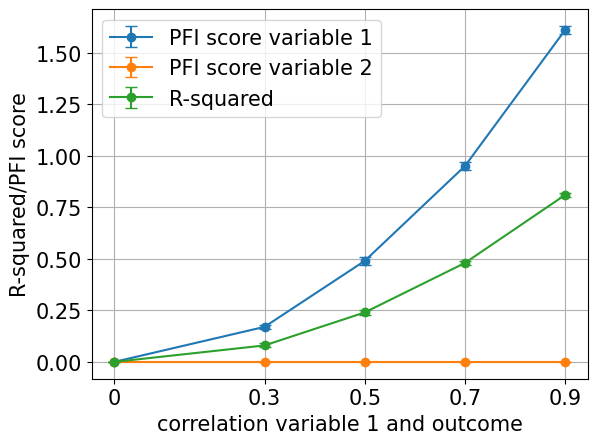

In [6]:
print(r2_list_01_err)
plt.errorbar(l, imp1_list_01_mean, yerr = imp1_list_01_err, marker='o', capsize=4)
plt.errorbar(l, imp2_list_01_mean, yerr = imp2_list_01_err, marker='o', capsize=4)
plt.errorbar(l, r2_list_01_mean, yerr = r2_list_01_err, marker='o', capsize=4)
plt.xticks(l,l)
plt.xlabel("correlation variable 1 and outcome")
plt.ylabel("R-squared/PFI score")
plt.legend(labels = ["PFI score variable 1", "PFI score variable 2", "R-squared"])
plt.grid()

Again, it works relatively well, with the permutation feature importance being approximately two times the correlation squared, and the r-squared is the correlation squared. <br>
In the next step, we set both correlations of the predictors to the outcome constant to 0.5 and vary the correlation between the two predictors.

In [7]:
mats = []

l = [0,0.3,0.5,0.7,0.9]

for q in l:
    matrix = [[1, 0.5, 0.5], [0.5, 1, q],[0.5, q, 1]]
    if all(np.linalg.eig(matrix)[0]>=0):
        mats.append(matrix)
    else:
        values = np.array([q, i, m])
        # Find the minimum index
        min_index = np.argmin(values)
        values[min_index] = 0.1
        matrix = [[1, values[1], values[0]], [values[1], 1, values[2]],[values[0], values[2], 1]]
        if all(np.linalg.eig(matrix)[0]>=0):
            mats.append(matrix)
        else:
            values[min_index] = 0.4
            matrix = [[1, values[1], values[0]], [values[1], 1, values[2]],[values[0], values[2], 1]]
            if all(np.linalg.eig(matrix)[0]>=0):
                mats.append(matrix)
            else:
                values[min_index] = 0.7
                matrix = [[1, values[1], values[0]], [values[1], 1, values[2]],[values[0], values[2], 1]]
                mats.append(matrix)
    print(matrix)

[[1, 0.5, 0.5], [0.5, 1, 0], [0.5, 0, 1]]
[[1, 0.5, 0.5], [0.5, 1, 0.3], [0.5, 0.3, 1]]
[[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]]
[[1, 0.5, 0.5], [0.5, 1, 0.7], [0.5, 0.7, 1]]
[[1, 0.5, 0.5], [0.5, 1, 0.9], [0.5, 0.9, 1]]


In [8]:
n = 5000
m = 100

r2_list_02 = [[0]*m for _ in range(len(mats))]
imp1_list_02 = [[0]*m for _ in range(len(mats))]
imp2_list_02 = [[0]*m for _ in range(len(mats))]

r2_list_02_mean = []
r2_list_02_err = []
imp1_list_02_mean = []
imp1_list_02_err = []
imp2_list_02_mean = []
imp2_list_02_err = [] 
# loop through all the matrices
for q in range(len(mats)):
    # define the means and the matrix
    mean = [0,0,0]
    matrix = mats[q]
    # create the datapoints for the hyperparameter tuning and split into X and y
    datamat = np.random.multivariate_normal(mean, matrix, n)
    y = datamat[:,0]
    X = pd.DataFrame(datamat[:,(1,2)])
    # define the distribution for the hyperparameter
    parameters = {
        'max_depth': [-1,3,5,7,10,13,16],
        'learning_rate': np.logspace(np.log10(0.01),np.log10(0.5), num = 20),
        'reg_alpha': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'reg_lambda': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'min_child_samples': [np.int64(x) for x in np.logspace(np.log10(1), np.log10(256), num = 20)],
        'n_estimators': [np.int64(x) for x in np.logspace(np.log10(50), np.log10(1000), num = 20)],
        'feature_fraction': [0.5,1],
        'bagging_fraction': np.logspace(np.log10(0.5),np.log10(1), num = 20),
    }
        
    lgb_regr = lgb.LGBMRegressor(random_state = 13, verbose = -1)
    CV = RandomizedSearchCV(estimator = lgb_regr, param_distributions = parameters, n_iter = 100, cv = 5)
    CV.fit(X, y)
    print(CV.best_estimator_)
    
    for i in range(m):
        datamat = np.random.multivariate_normal(mean, matrix, 5000)
        y = pd.DataFrame(datamat[:,0])
        X = pd.DataFrame(datamat[:,(1,2)])
        datamat_test = np.random.multivariate_normal(mean, matrix, 5000)
        y_test = pd.DataFrame(datamat_test[:,0])
        X_test = pd.DataFrame(datamat_test[:,(1,2)])

        lgb_regr_fin = CV.best_estimator_
        lgb_regr_fin.fit(X, y)
        result = permutation_importance(lgb_regr_fin, X_test, y_test, n_repeats=50)
        predictions = lgb_regr_fin.predict(X_test)
        r2 = round(r2_score(y_test, predictions), 2)
        r2_list_02[q][i] = r2
        imp1_list_02[q][i] = result.importances_mean[0]
        imp2_list_02[q][i] = result.importances_mean[1]
    mean_imp1 = round(np.mean(imp1_list_02[q]),2)
    imp1_list_02_mean.append(mean_imp1)
    std_imp1 = round(np.std(imp1_list_02[q]),2)
    imp1_list_02_err.append(std_imp1)
    mean_imp2 = round(np.mean(imp2_list_02[q]),2)
    imp2_list_02_mean.append(mean_imp2)
    std_imp2 = round(np.std(imp2_list_02[q]),2)
    imp2_list_02_err.append(std_imp2)
    mean_r2 = round(np.mean(r2_list_02[q]),2)
    r2_list_02_mean.append(mean_r2)
    std_r2 = round(np.std(r2_list_02[q]),2)
    r2_list_02_err.append(std_r2)
    print('For the Matrix: ')
    print(matrix)
    print('mean_r2: {}, standard deviation: {}' .format(mean_r2, std_r2))
    print('feature1 importances: {}, standard deviation: {}' .format(mean_imp1, std_imp1))
    print('feature2 importances: {}, standard deviation: {}' .format(mean_imp2, std_imp2))


LGBMRegressor(bagging_fraction=0.6223462947320116, feature_fraction=0.5,
              learning_rate=0.051922523468393586, max_depth=3,
              min_child_samples=1, n_estimators=128, random_state=13,
              reg_alpha=0.16237767391887217, reg_lambda=1.8329807108324356,
              verbose=-1)
For the Matrix: 
[[1, 0.5, 0.5], [0.5, 1, 0], [0.5, 0, 1]]
mean_r2: 0.49, standard deviation: 0.01
feature1 importances: 0.48, standard deviation: 0.02
feature2 importances: 0.48, standard deviation: 0.02
LGBMRegressor(bagging_fraction=0.8642218932816056, feature_fraction=0.5,
              learning_rate=0.07837810140573315, max_depth=3,
              min_child_samples=79, n_estimators=241, random_state=13,
              reg_alpha=7.847599703514611, reg_lambda=7.847599703514611,
              verbose=-1)
For the Matrix: 
[[1, 0.5, 0.5], [0.5, 1, 0.3], [0.5, 0.3, 1]]
mean_r2: 0.38, standard deviation: 0.01
feature1 importances: 0.29, standard deviation: 0.01
feature2 importances: 0.29

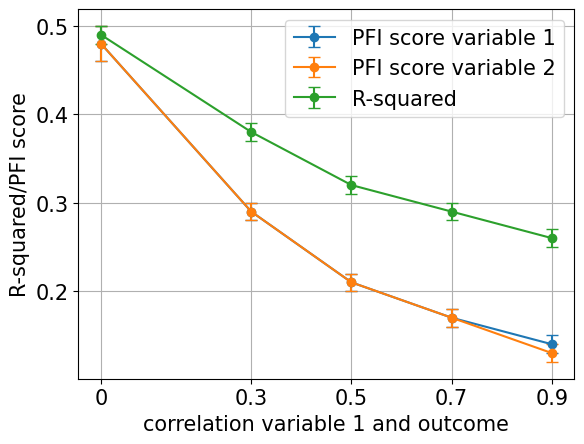

In [9]:
plt.errorbar(l, imp1_list_02_mean, yerr = imp1_list_02_err, marker='o', capsize=4)
plt.errorbar(l, imp2_list_02_mean, yerr = imp2_list_02_err, marker='o', capsize=4)
plt.errorbar(l, r2_list_02_mean, yerr = r2_list_02_err, marker='o', capsize=4)
plt.xticks(l,l)
plt.xlabel("correlation variable 1 and outcome")
plt.ylabel("R-squared/PFI score")
plt.legend(labels = ["PFI score variable 1", "PFI score variable 2", "R-squared"])
plt.grid()

We can see, that with a rising correlation between the two variables, both the r-squared as well as the PFI-score get smaller. This is likely due to the fact, that the two variables carry the same information to the outcome and if one gets permuted, the other can still provide some of the information. The resulting PFI score is, however, slightly slower than what would be expected given the r-squared. So the PFI-score seems to underestimate the importance of the variables. <br>
Now let's set the predictors to different correlations with the outcome and again vary the correlation between the predictors.

In [10]:
mats = []

l = [0,0.3,0.5,0.7,0.9]
COV_1 = 0.5
COV_2 = 0

for q in l:
    matrix = [[1, COV_1, COV_2], [COV_1, 1, q],[COV_2, q, 1]]
    if all(np.linalg.eig(matrix)[0]>=0):
        mats.append(matrix)
    else:
        values = np.array([q, COV_1, COV_2])
        # Find the minimum index
        min_index = np.argmin(values)
        values[min_index] = 0.1
        matrix = [[1, values[1], values[2]], [values[1], 1, values[0]],[values[2], values[0], 1]]
        if all(np.linalg.eig(matrix)[0]>=0):
            mats.append(matrix)
        else:
            values[min_index] = 0.4
            matrix = [[1, values[1], values[2]], [values[1], 1, values[0]],[values[2], values[0], 1]]
            if all(np.linalg.eig(matrix)[0]>=0):
                mats.append(matrix)
            else:
                values[min_index] = 0.7
                matrix = [[1, values[1], values[2]], [values[1], 1, values[0]],[values[2], values[0], 1]]
                mats.append(matrix)
    print(matrix)

[[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]]
[[1, 0.5, 0], [0.5, 1, 0.3], [0, 0.3, 1]]
[[1, 0.5, 0], [0.5, 1, 0.5], [0, 0.5, 1]]
[[1, 0.5, 0], [0.5, 1, 0.7], [0, 0.7, 1]]
[[1, 0.5, 0.1], [0.5, 1, 0.9], [0.1, 0.9, 1]]


In [11]:
n = 5000
m = 100

r2_list_03 = [[0]*m for _ in range(len(mats))]
imp1_list_03 = [[0]*m for _ in range(len(mats))]
imp2_list_03 = [[0]*m for _ in range(len(mats))]

r2_list_03_mean = []
r2_list_03_err = []
imp1_list_03_mean = []
imp1_list_03_err = []
imp2_list_03_mean = []
imp2_list_03_err = [] 
# loop through all the matrices
for q in range(len(mats)):
    # define the means and the matrix
    mean = [0,0,0]
    matrix = mats[q]
    # create the datapoints for the hyperparameter tuning and split into X and y
    datamat = np.random.multivariate_normal(mean, matrix, n)
    y = datamat[:,0]
    X = pd.DataFrame(datamat[:,(1,2)])
    # define the distribution for the hyperparameter
    parameters = {
        'max_depth': [-1,3,5,7,10,13,16],
        'learning_rate': np.logspace(np.log10(0.01),np.log10(0.5), num = 20),
        'reg_alpha': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'reg_lambda': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'min_child_samples': [np.int64(x) for x in np.logspace(np.log10(1), np.log10(256), num = 20)],
        'n_estimators': [np.int64(x) for x in np.logspace(np.log10(50), np.log10(1000), num = 20)],
        'feature_fraction': [0.5,1],
        'bagging_fraction': np.logspace(np.log10(0.5),np.log10(1), num = 20),
    }
        
    lgb_regr = lgb.LGBMRegressor(random_state = 13, verbose = -1)
    CV = RandomizedSearchCV(estimator = lgb_regr, param_distributions = parameters, n_iter = 100, cv = 5)
    CV.fit(X, y)
    print(CV.best_estimator_)
    
    for i in range(m):
        datamat = np.random.multivariate_normal(mean, matrix, 5000)
        y = pd.DataFrame(datamat[:,0])
        X = pd.DataFrame(datamat[:,(1,2)])
        datamat_test = np.random.multivariate_normal(mean, matrix, 5000)
        y_test = pd.DataFrame(datamat_test[:,0])
        X_test = pd.DataFrame(datamat_test[:,(1,2)])

        lgb_regr_fin = CV.best_estimator_
        lgb_regr_fin.fit(X, y)
        result = permutation_importance(lgb_regr_fin, X_test, y_test, n_repeats=50)
        predictions = lgb_regr_fin.predict(X_test)
        r2 = round(r2_score(y_test, predictions), 2)
        r2_list_03[q][i] = r2
        imp1_list_03[q][i] = result.importances_mean[0]
        imp2_list_03[q][i] = result.importances_mean[1]
    mean_imp1 = round(np.mean(imp1_list_03[q]),2)
    imp1_list_03_mean.append(mean_imp1)
    std_imp1 = round(np.std(imp1_list_03[q]),2)
    imp1_list_03_err.append(std_imp1)
    mean_imp2 = round(np.mean(imp2_list_03[q]),2)
    imp2_list_03_mean.append(mean_imp2)
    std_imp2 = round(np.std(imp2_list_03[q]),2)
    imp2_list_03_err.append(std_imp2)
    mean_r2 = round(np.mean(r2_list_03[q]),2)
    r2_list_03_mean.append(mean_r2)
    std_r2 = round(np.std(r2_list_03[q]),2)
    r2_list_03_err.append(std_r2)
    print('For the Matrix: ')
    print(matrix)
    print('mean_r2: {}, standard deviation: {}' .format(mean_r2, std_r2))
    print('feature1 importances: {}, standard deviation: {}' .format(mean_imp1, std_imp1))
    print('feature2 importances: {}, standard deviation: {}' .format(mean_imp2, std_imp2))

LGBMRegressor(bagging_fraction=0.8034112265668824, feature_fraction=1,
              learning_rate=0.01, max_depth=3, min_child_samples=1,
              n_estimators=454, random_state=13, reg_alpha=0.20691380811147897,
              reg_lambda=6.158482110660261, verbose=-1)
For the Matrix: 
[[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]]
mean_r2: 0.24, standard deviation: 0.01
feature1 importances: 0.49, standard deviation: 0.02
feature2 importances: -0.0, standard deviation: 0.0
LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.5,
              learning_rate=0.17859637297609765, max_depth=3,
              min_child_samples=5, n_estimators=49, random_state=13,
              reg_alpha=10.0, reg_lambda=0.20691380811147897, verbose=-1)
For the Matrix: 
[[1, 0.5, 0], [0.5, 1, 0.3], [0, 0.3, 1]]
mean_r2: 0.26, standard deviation: 0.01
feature1 importances: 0.56, standard deviation: 0.02
feature2 importances: 0.04, standard deviation: 0.01
LGBMRegressor(bagging_fraction=0.7468794808272429, featur

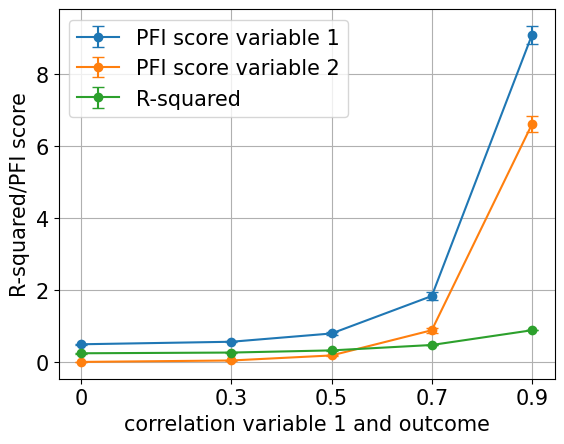

In [12]:
plt.errorbar(l, imp1_list_03_mean, yerr = imp1_list_03_err, marker='o', capsize=4)
plt.errorbar(l, imp2_list_03_mean, yerr = imp2_list_03_err, marker='o', capsize=4)
plt.errorbar(l, r2_list_03_mean, yerr = r2_list_03_err, marker='o', capsize=4)
plt.xticks(l,l)
plt.xlabel("correlation variable 1 and outcome")
plt.ylabel("R-squared/PFI score")
plt.legend(labels = ["PFI score variable 1", "PFI score variable 2", "R-squared"])
plt.grid()

We now see a very different behavior, as both the r-squared as well as the feature permutation importance scores rise with a rising correlation between the two predictor variables. Further, while there is a rise in the r-square score, the rise in the PFI-score is even more evident, so the PFI score seems to overestimate the importance of the variables. <br>
As a final example, let us set both predictor variables to be correlated to the outcome but at a different strength and vary the correlation between the predictors again.

In [13]:
mats = []

l = [0,0.3,0.5,0.7,0.9]
COV_1 = 0.7
COV_2 = 0.3

for q in l:
    matrix = [[1, COV_1, COV_2], [COV_1, 1, q],[COV_2, q, 1]]
    if all(np.linalg.eig(matrix)[0]>=0):
        mats.append(matrix)
    else:
        values = np.array([q, COV_1, COV_2])
        # Find the minimum index
        min_index = np.argmin(values)
        values[min_index] = 0.1
        matrix = [[1, values[1], values[2]], [values[1], 1, values[0]],[values[2], values[0], 1]]
        if all(np.linalg.eig(matrix)[0]>=0):
            mats.append(matrix)
        else:
            values[min_index] = 0.4
            matrix = [[1, values[1], values[2]], [values[1], 1, values[0]],[values[2], values[0], 1]]
            if all(np.linalg.eig(matrix)[0]>=0):
                mats.append(matrix)
            else:
                values[min_index] = 0.7
                matrix = [[1, values[1], values[2]], [values[1], 1, values[0]],[values[2], values[0], 1]]
                mats.append(matrix)
    print(matrix)

[[1, 0.7, 0.3], [0.7, 1, 0], [0.3, 0, 1]]
[[1, 0.7, 0.3], [0.7, 1, 0.3], [0.3, 0.3, 1]]
[[1, 0.7, 0.3], [0.7, 1, 0.5], [0.3, 0.5, 1]]
[[1, 0.7, 0.3], [0.7, 1, 0.7], [0.3, 0.7, 1]]
[[1, 0.7, 0.4], [0.7, 1, 0.9], [0.4, 0.9, 1]]


In [14]:
n = 5000
m = 100

r2_list_04 = [[0]*m for _ in range(len(mats))]
imp1_list_04 = [[0]*m for _ in range(len(mats))]
imp2_list_04 = [[0]*m for _ in range(len(mats))]

r2_list_04_mean = []
r2_list_04_err = []
imp1_list_04_mean = []
imp1_list_04_err = []
imp2_list_04_mean = []
imp2_list_04_err = [] 
# loop through all the matrices
for q in range(len(mats)):
    # define the means and the matrix
    mean = [0,0,0]
    matrix = mats[q]
    # create the datapoints for the hyperparameter tuning and split into X and y
    datamat = np.random.multivariate_normal(mean, matrix, n)
    y = datamat[:,0]
    X = pd.DataFrame(datamat[:,(1,2)])
    # define the distribution for the hyperparameter
    parameters = {
        'max_depth': [-1,3,5,7,10,13,16],
        'learning_rate': np.logspace(np.log10(0.01),np.log10(0.5), num = 20),
        'reg_alpha': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'reg_lambda': np.logspace(np.log10(0.1),np.log10(10), num = 20),
        'min_child_samples': [np.int64(x) for x in np.logspace(np.log10(1), np.log10(256), num = 20)],
        'n_estimators': [np.int64(x) for x in np.logspace(np.log10(50), np.log10(1000), num = 20)],
        'feature_fraction': [0.5,1],
        'bagging_fraction': np.logspace(np.log10(0.5),np.log10(1), num = 20),
    }
        
    lgb_regr = lgb.LGBMRegressor(random_state = 13, verbose = -1)
    CV = RandomizedSearchCV(estimator = lgb_regr, param_distributions = parameters, n_iter = 100, cv = 5)
    CV.fit(X, y)
    print(CV.best_estimator_)
    
    for i in range(m):
        datamat = np.random.multivariate_normal(mean, matrix, 5000)
        y = pd.DataFrame(datamat[:,0])
        X = pd.DataFrame(datamat[:,(1,2)])
        datamat_test = np.random.multivariate_normal(mean, matrix, 5000)
        y_test = pd.DataFrame(datamat_test[:,0])
        X_test = pd.DataFrame(datamat_test[:,(1,2)])

        lgb_regr_fin = CV.best_estimator_
        lgb_regr_fin.fit(X, y)
        result = permutation_importance(lgb_regr_fin, X_test, y_test, n_repeats=50)
        predictions = lgb_regr_fin.predict(X_test)
        r2 = round(r2_score(y_test, predictions), 2)
        r2_list_04[q][i] = r2
        imp1_list_04[q][i] = result.importances_mean[0]
        imp2_list_04[q][i] = result.importances_mean[1]
    mean_imp1 = round(np.mean(imp1_list_04[q]),2)
    imp1_list_04_mean.append(mean_imp1)
    std_imp1 = round(np.std(imp1_list_04[q]),2)
    imp1_list_04_err.append(std_imp1)
    mean_imp2 = round(np.mean(imp2_list_04[q]),2)
    imp2_list_04_mean.append(mean_imp2)
    std_imp2 = round(np.std(imp2_list_04[q]),2)
    imp2_list_04_err.append(std_imp2)
    mean_r2 = round(np.mean(r2_list_04[q]),2)
    r2_list_04_mean.append(mean_r2)
    std_r2 = round(np.std(r2_list_04[q]),2)
    r2_list_04_err.append(std_r2)
    print('For the Matrix: ')
    print(matrix)
    print('mean_r2: {}, standard deviation: {}' .format(mean_r2, std_r2))
    print('feature1 importances: {}, standard deviation: {}' .format(mean_imp1, std_imp1))
    print('feature2 importances: {}, standard deviation: {}' .format(mean_imp2, std_imp2))

LGBMRegressor(bagging_fraction=1.0, feature_fraction=0.5,
              learning_rate=0.018546348734442802, max_depth=3,
              min_child_samples=1, n_estimators=388, random_state=13,
              reg_alpha=0.33598182862837817, reg_lambda=3.79269019073225,
              verbose=-1)
For the Matrix: 
[[1, 0.7, 0.3], [0.7, 1, 0], [0.3, 0, 1]]
mean_r2: 0.57, standard deviation: 0.01
feature1 importances: 0.94, standard deviation: 0.02
feature2 importances: 0.17, standard deviation: 0.01
LGBMRegressor(bagging_fraction=0.7468794808272429, feature_fraction=0.5,
              learning_rate=0.2695948443325881, max_depth=3,
              min_child_samples=59, n_estimators=454, random_state=13,
              reg_alpha=10.0, reg_lambda=0.8858667904100825, verbose=-1)
For the Matrix: 
[[1, 0.7, 0.3], [0.7, 1, 0.3], [0.3, 0.3, 1]]
mean_r2: 0.49, standard deviation: 0.01
feature1 importances: 0.88, standard deviation: 0.02
feature2 importances: 0.02, standard deviation: 0.0
LGBMRegressor(bagg

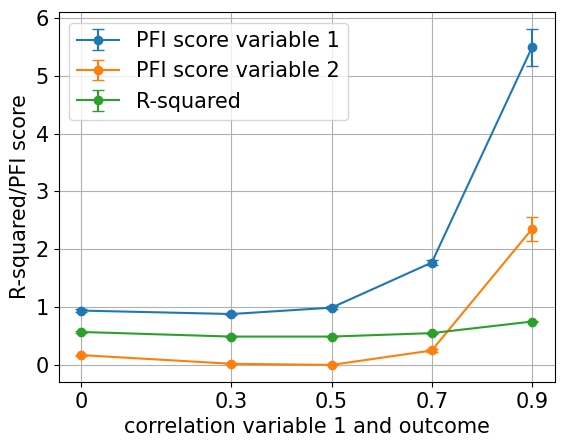

In [15]:
plt.errorbar(l, imp1_list_04_mean, yerr = imp1_list_04_err, marker='o', capsize=4)
plt.errorbar(l, imp2_list_04_mean, yerr = imp2_list_04_err, marker='o', capsize=4)
plt.errorbar(l, r2_list_04_mean, yerr = r2_list_04_err, marker='o', capsize=4)
plt.xticks(l,l)
plt.xlabel("correlation variable 1 and outcome")
plt.ylabel("R-squared/PFI score")
plt.legend(labels = ["PFI score variable 1", "PFI score variable 2", "R-squared"])
plt.grid()

We see that at first the r-squared and the PFI-scores get smaller, but they rise again at some point. So, we can see the PFI score both underestimating and overestimating the importance of a predictor variable. <br>
This notebook shows again, that PFI scores are biased in the presence of correlated predictor variables. The theory is that PFI breaks existing datastructures and creates unrealistic samples, forcing the model to extrapolate, leading to bad performance. But the notebook also shows that the PFI works quite well in uncorrelated predictors. <br>
For further information on the bias of PFI in correlated predictor variables and the general problem of such permutation approaches, I would suggest to look at some of the following papers:

- Hooker, G., Mentch, L., & Zhou, S. (2021). Unrestricted permutation forces extrapolation: variable importance requires at least one more model, or there is no free variable importance. *Statistics and Computing, 31*, 1–16.
- Strobl, C., Boulesteix, A.-L., Kneib, T., Augustin, T., & Zeileis, A. (2008). Conditional variable importance for random forests. *BMC Bioinformatics, 9*(307), 1 – 11. doi: 10.1186/1471-2105-9-307

A possible alternative was suggested by Strobl et al., 2008, and is called "conditional PFI". It basically permutes the variables considering the datastructure and the correlation with other predictor variables. To my knowledge, it is so far only implemented as an r-package "permimp", but not in any python package. For more information see Strobl as cited above, or:
- Debeer, D., & Strobl, C. (2020). Conditional permutation importance revisited. BMC bioinformatics, 21(1), 307. https://doi.org/10.1186/s12859-020-03622-2
- Molnar, C., König, G., Bischl, B., & Casalicchio, G. (2023). Model-agnostic feature importance and effects with dependent features: a conditional subgroup approach. *Data Mining and Knowledge Discovery, 38*, 1-39. doi: 10.1007/s10618-022-00901-9